In [15]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
import os, time, itertools
#import seaborn as sns

In [3]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Overview

A **support vector machine (SVM)** is partitions your space into 2 volumes separated by a hyperplane, effectivesly separating two classes. The training involves finding this hyperplane.

<img src=https://www.aitrends.com/wp-content/uploads/2018/01/1-19SVM-2.jpg width=250> 

A **support vector classifier (SVC)** combines many SVMs to allow for multiple classifications.

**Kernel SVMs** transform your features such that you may have non-linear hyperplanes.

## SVM

Assume a decision boundary $\textbf{w}^T\textbf{x} + b = 0$ that separates 2 classes, where the normal to the hyperplan is $\textbf{w}^T$. For any data point $\textbf{x}_i$ the sign of $\textbf{w}^T\textbf{x}_i + b$ determines on which side of the boundary it is found (i.e. which class the data point belongs to). We can classify

1. if $\textbf{w}^T\textbf{x}_i + b \geq 1$, then $y_i=1$
2. if if $\textbf{w}^T\textbf{x}_i + b \leq -1$, then $y_i=-1$

This lets us check if the classification is correct: $y_i(\textbf{w}^T\textbf{x}_i + b)\geq 0 $.

Note that a variety of $\textbf{w}$ and $b$ that allow for this to be true. However, we'll look for the hyperplane that maximizes the distance between the two boundaries, $\textbf{w}^T\textbf{x}_i + b = -1$ and $\textbf{w}^T\textbf{x}_i + b = 1$. Simple calculation shows that this distance is $d=2/\sqrt{\textbf{w}^T\textbf{w}}$.

The optimization problem we need to solve is then

$$min_{\textbf{w}}\frac{\textbf{w}^T\textbf{w}}{2} \rightarrow min_{\textbf{w},b}\frac{||w||^2}{2}$$
subject to $$y_i(\textbf{w}^T\textbf{x}_i + b) -1 \geq 0 \quad \forall \textbf{x}_i$$

This optimization problem can equivalently be described as the minimization of the Lagrangian

$$L=\frac{||w||^2}{2}-\sum_i \lambda_i (y_i(\textbf{w}^T\textbf{x}_i + b) - 1)$$

which we can solve various optimization strategies. Another way to write this is, to allow for getting $y_i(\textbf{w}^T\textbf{x}_i + b)$ as close as possible to 1 is:

$$L=\frac{||w||^2}{2}+\sum_i max_{\lambda_i\geq0}\lambda_i (1 - y_i(\textbf{w}^T\textbf{x}_i + b))$$

Note that  to prevent $\lambda_i$ from going to infitity for penalizing misclassified points, we may still have a condition $0\leq\lambda_i\leq C$. 


### Soft margin (alternative method)

In some instances the data is not completely linearly separable, there may be some noise around the boundary (or mislabelled points). To allow for noisy data, you can allow for some points to cross the boundary

$$min_{\textbf{w},\textbf{$\epsilon$}}\frac{||w||^2}{2}+C\sum_i \epsilon_i$$
subject to $$y_i(\textbf{w}^T\textbf{x}_i + b) - 1 + \epsilon_i \geq 0 \quad \forall \textbf{x}_i$$

Similar Lagrangian and optimization follow.


### Dual optimization

The dual optimization problem is 

$$max_{\lambda \geq 0} [min_{\textbf{w},b} L(\textbf{w},b;\lambda) ]$$
$$ L = \frac{||w||^2}{2}+\sum_i max_{\lambda_i\geq0}\lambda_i (1 - y_i(\textbf{w}^T\textbf{x}_i + b))$$

The minimization gives us subsitution from $\partial L/\partial w_i=0$ ($\textbf{w}=\sum_i \lambda_i y_i \textbf{x}_i$) and $\partial L/\partial b = 0$. Our optimization problem is now

$$max_{\lambda \geq 0}\left[\sum_i \lambda_i - \frac{1}{2}\sum_{i,j} \lambda_i \lambda_j y_i y_j {\textbf{x}_i}^T\textbf{x}_j\right]$$

under constraints $0\leq\lambda_i\leq C$ and $\sum_i \lambda_i y_i = 0$. This can then be solved using any maximization optimization strategy (e.g. Sequential Minimization Optimization (SMO), gradient descent?)

## Kernel trick

Suppose you want to transform your features into some other coordinate system or come up with some clever combination of your features. Take a mapping from the vector space of your data $V$ into another vector space (potentially infinite dimensional) $W$

$$ \phi : V \rightarrow W $$.

For example  $\textbf{x} = (x_1,x_2) \in {\rm I\!R}^2$, however we have a function $\phi : {\rm I\!R}^2 \rightarrow {\rm I\!R}^d$ such that $\phi (x) = (1,x_1,x_2,x_1 x_2, {x_1}^2, {x_2}^2, , x_2{x_1}^2...)$.

Our above derivation holds for the transformed data $\phi(\textbf{x}_i)$, and we get the same results except ${\textbf{x}_i}^T\textbf{x}_j \rightarrow \phi(\textbf{x}_i)^T \phi(\textbf{x}_j)$. Why is this useful? Well, it turns out that there are ways to simplify this dot product for given functions $\phi$, such that it's simpler than calculating the whole function for each data point and then performing a dot product. This is what is known as the kernel trick.

$$\phi(\textbf{x})^T\phi(\textbf{y}) = K(\textbf{x},\textbf{y})$$

### Common examples of kernels

1. Polynomial kernel
$\textbf{x}\in{\rm I\!R}^N$, with $\phi : {\rm I\!R}^N \rightarrow {\rm I\!R}^M$ such that $\phi(\textbf{x})$ is a polynomial of degree d

$$\phi(\textbf{x})^T\phi(\textbf{y}) = (1+\textbf{x}^T\textbf{y})^d = K_{poly}(\textbf{x},\textbf{y})$$

2. Radial basis function kernel (gaussian kernel)

$$\phi(\textbf{x})^T\phi(\textbf{y}) = e^{||\textbf{x} - \textbf{y}||^2/2\sigma^2} = K_{rbf}(\textbf{x},\textbf{y})$$


## Classification

Once you've learned $\lambda_i$, classification of any new data point $\textbf{z}$ is simply found by calculating

$$sign(\textbf{w}^T\phi(\textbf{z})+b)=\sum_i\lambda_i y_i K(\textbf{x}_i,\textbf{z}) + b$$

Note that from our optimization strategy, the only non-zero $\lambda_i$ are the ones$\textbf{z} associated to points $\textbf{x}_i$ close to the boundary: these are our support vectors.


### Multiclassifiers

I did not get to look much into this, except that I found the most common strategy was one-vs-rest approach. For $N$ classes, train $N$ binary SVMs such that for each class the SVM has finds classifies between members of the class vs all other classes. Another approache is one-vs-one, but there are more sophisticated choices.

### Comments

**Pros**
1. Kernel trick allows for different combinations features without increasing run time
2. Kernel choice determines if you're overfitting, conservative choices of kernel mean no overftting
3. Not many hyperparameters

**Cons**
1. Memory for kernel trick is $O(n^2)$
3. Training $O(|x|\cdot n^2)$



### Example : Breast Cancer Wisconsin, Iris

In [8]:
from sklearn.datasets import load_breast_cancer, load_iris, load_digits, load_wine
from sklearn import svm

dataset = load_digits()

features = [0,1]
feature_label = [dataset.feature_names[features[0]], dataset.feature_names[features[1]]]
X = dataset.data[:, features]
y = dataset.target
print(dataset.target_names)
print(dataset.feature_names)

[0 1 2 3 4 5 6 7 8 9]
['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']


[]

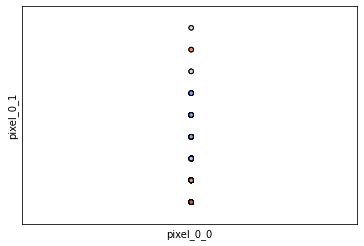

In [18]:
fig, ax = plt.subplots()

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(feature_label[0])
ax.set_ylabel(feature_label[1])
ax.set_xticks(())
ax.set_yticks(())

In [19]:
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=100000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

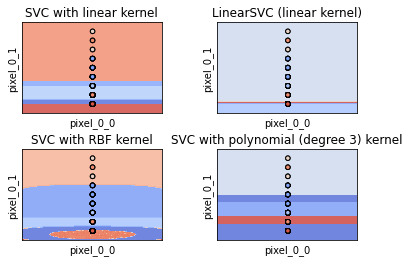

In [20]:
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(feature_label[0])
    ax.set_ylabel(feature_label[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

### Example 2 : Prediction

In [18]:
from keras.datasets import mnist
(X_train_raw, y_train), (X_test_raw, y_test) = mnist.load_data()

#X_train_raw = train_X.reshape(train_X.shape[0], 28, 28, 1)
#test_X_raw = test_X.reshape(test_X.shape[0], 28, 28, 1)

num_features = X_train_raw.shape[1]*X_train_raw.shape[2]

X_train, X_test = X_train_raw.reshape([-1, num_features]), X_test_raw.reshape([-1, num_features])

print(X_train.shape)

(60000, 784)


In [ ]:
from sklearn.model_selection import train_test_split

dataset = load_digits()
#flatten
n_samples = len(dataset.images)
data = dataset.images.reshape((n_samples, -1))

# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, dataset.target, test_size=0.3, shuffle=False)

In [ ]:
# Learn the digits on the train subset
clf = svm.SVC(gamma=0.001)
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(X_train_raw.shape[1], X_train_raw.shape[2])
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Prediction: {prediction}')